# Tutorial 5 at NTU: Deep Learning in Finance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
tf.random.set_seed(12345)

from PIL import Image
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from scikitplot.metrics import plot_roc
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [ ]:
class WindowGenerator():
    """
    From https://www.tensorflow.org/tutorials/structured_data/time_series
    """
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
      inputs = features[:, self.input_slice, :]
      labels = features[:, self.labels_slice, :]
      if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
      inputs.set_shape([None, self.input_width, None])
      labels.set_shape([None, self.label_width, None])
      return inputs, labels

    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time [h]')

    def make_dataset(self, data):
      data = np.array(data, dtype=np.float32)
      ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

      ds = ds.map(self.split_window)

      return ds

    @property
    def train(self):
      return self.make_dataset(self.train_df)

    @property
    def val(self):
      return self.make_dataset(self.val_df)

    @property
    def test(self):
      return self.make_dataset(self.test_df)

    @property
    def example(self):
      """Get and cache an example batch of `inputs, labels` for plotting."""
      result = getattr(self, '_example', None)
      if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
      return result

In [ ]:
CMAP = sns.diverging_palette(20, 220, as_cmap=True)

def pretty_heatmap(df, figsize=(10, 5), title=None, annot=True, **kwargs):
    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle(title, y=1)
    sns.heatmap(df, annot=annot, cmap=CMAP, ax=ax, cbar=False, **kwargs)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:
def show_image(name, figsize=(12, 8)):
    try:
        img = Image.open(f"{name}.png")
    except FileNotFoundError:
        print("Error: Image file not found.")
        exit(1)

    title = name.replace('_', ' ').title()
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

## 1. Introduction

Artificial neural networks have a long history in financial and economic statistics.

Most recently, the literature has been extended to include deep neural networks.

For now, we shall introduce some of the <b>theory of function approximation</b> with neural networks given i.i.d observation points.

## 2. Feedforward Architectures

FNN are a form of <b>supervised machine learning</b> that use hierarchical layers to represent high-dimensional non-linear predictors.

The traditional notion of statistical significance has been replaced in ML literature by <b>out-of-sample forecasting</b> and understanding <b> bias–variance tradeoff </b>.

Deep learning is data-driven and focuses on finding structure in large datasets.

### 2.1 Geometric Interpretation

We begin by considering a simple feedforward binary classifier with only two features.

The simplest configuration we shall consider has just two inputs and one binary output unit—this is a logistic regression model.

\
Next, consider a 1-layer network, with the number of hidden units equal to the number of input neurons.

This choice serves as a useful reference point for its interpretability.

\
The final configuration has substantially more hidden units. This set of simple architectures illustrate how a neural network works in general.

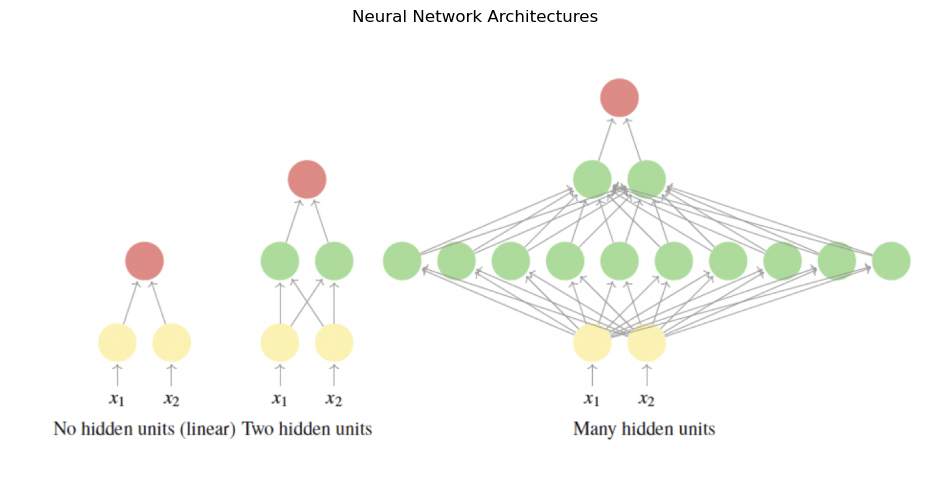

In [ ]:
show_image('neural_network_architectures')

In the below figure, the data has been arranged so that no separating linear plane can perfectly separate the points in $[1,1] \times [1,1]$.

The activation function is chosen to be ReLU(x). The weight and biases of the network have been trained on this data.

\
From the top row of the figure, we can observe how the input space is transformed by the hidden layer in each network.

We can also view the decision boundaries in the original input space from the bottom row of the figure.

The number of units in the first hidden layers is observed to significantly affect the classifier performance.

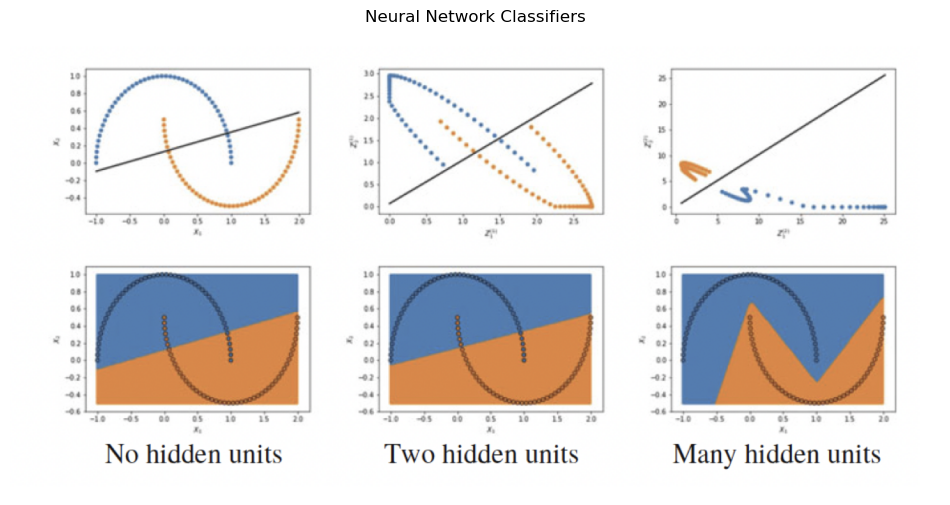

In [ ]:
show_image('neural_network_classifiers')

### 2.2 Partition

The <b>partitioning of the input space </b> is a distinguishing feature of neural networks.

Each hidden unit defines a manifold which divides the input space into <b>convex regions</b>.

In other words, each unit in the hidden layer implements a half-space predictor.

\
In the case of a ReLU activation function $ f(x) = \max(x, 0) $,

each manifold is simply a hyperplane and the neuron gets activated when the observation is on the “best” side of this hyperplane,

the activation amount is equal to how far from the boundary the given point is.

## 3. Activation Functions

Non-linearity is essential to a deep neural network. Otherwise, it is just a linear regression model.

The activation function introduces non-linearity into the perceptron's work so as to consider different linear relationships of inputs.

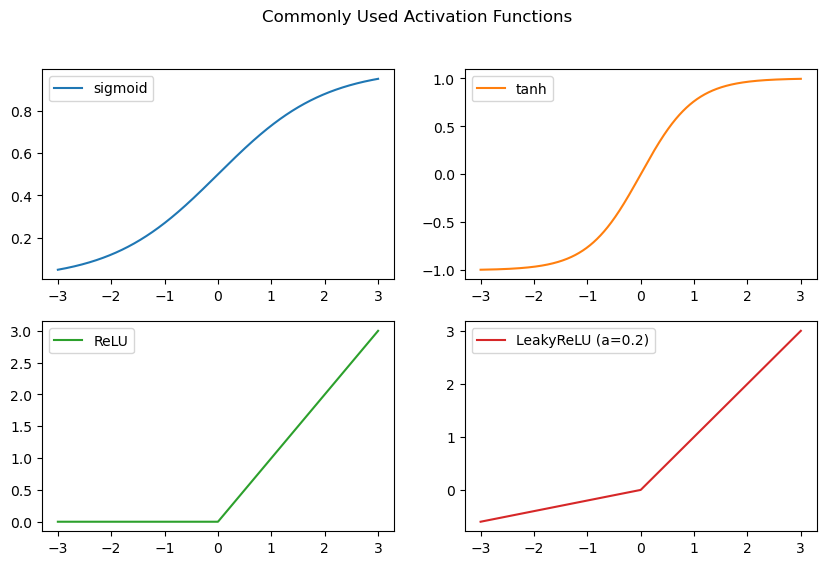

In [ ]:
x = np.linspace(-3, 3, 1000)
a = 0.2
activs = pd.DataFrame({'sigmoid': 1 / (1 + np.exp(-x)),
                       'tanh': (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)),
                       'ReLU': np.where(x > 0, x, 0),
                       f'LeakyReLU (a={a})': np.where(x > 0, x, a * x)},
                       index=x)

activs.plot(title='Commonly Used Activation Functions',
            subplots=True, layout=(2, 2), figsize=(10, 6),
            sharex=False, sharey=False);

### 3.1 Desirable properties of non-linearity

- Allow back-propagation because they have a derivative function which is related to the inputs.
- Allow "stacking" of multiple layers of neurons to create a deep neural network.

### 3.2 Possible Problems

- Vanishing gradient problem for both sigmoid and tanh, thus slow convergence;
- Dying ReLU problem: when inputs approach zero, or are negative, <br>
  the gradient of the function becomes zero, the network cannot perform back-propagation and cannot learn.

### 3.3 When to use which?

It is not possible to recommend an activation function that works for all use cases.

It really depends on the situation and your own preference.

1. ReLU is widely used and most people just simply use it as it yields better results generally;
2. ReLU function should only be used in the hidden layers but not output.
3. Sigmoid function generally work better in classification problems;
4. You may not use sigmoid and tanh due to the vanishing gradient problem.

## 4. Backpropagation

The back propagation algorithm is probably the <b>most fundamental building block</b> in training a neural network.

Through Chain Rule, after each forward pass through a network,

backpropagation performs a backward pass while adjusting the model’s parameters.

### 4.1  Computational Graph of Forward Propagation

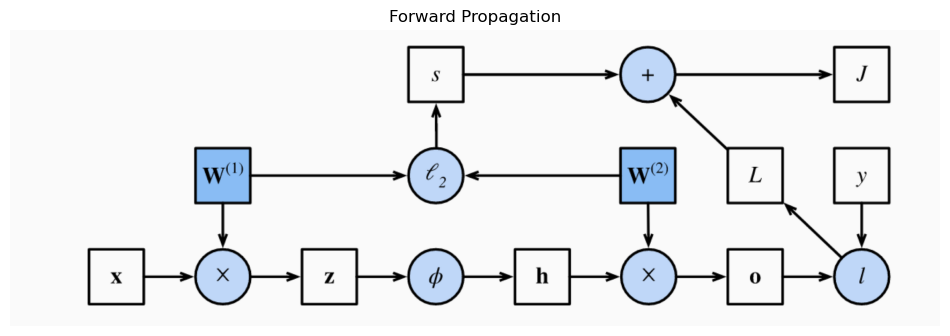

In [ ]:
show_image('Forward Propagation')

Plotting computational graphs helps us visualize the dependencies of operators and variables within the calculation.

It shows two parts of a Neural Network:

1. How the output ```o``` is computed
2. How the objective function ```J``` is computed from loss function ```L``` and regularization ```s```

### 4.2 Relationship between Back and Forward Propagation

As the final step in a forward propagation is to evaluate the predicted outputs against an expected output,

we may then evaluate the differences/errors between the true and predicted outcome through a cost function.

This can be as simple as MSE (mean squared error) or more complex like cross-entropy.

\
Based on the ”error”, the model “knows” how much to adjust its parameters in order to get closer to the true expected output $y$.

This happens using the backpropagation algorithm.

### 4.3 Illustrating Example

Consider the below neural network, with four inputs and two hidden layers with two neurons.

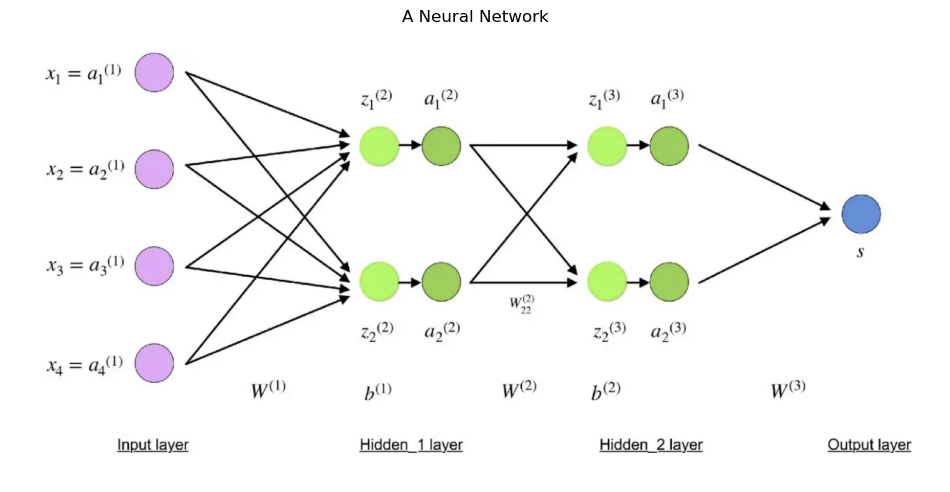

In [ ]:
show_image('A Neural Network')

#### 4.3.1 Cost Function

Cost function (denote it as $C$) measures the performance of a machine learning model for given data.

$C$ quantifies the error between predicted and expected values and present that error in the form of a single real number.

\
At the heart of backpropagation is the expression for the partial derivative $\frac{\partial C}{\partial w}$ and $\frac{\partial C}{\partial b}$.

The expression tells us how quickly the cost changes when we change the weights and biases.

#### 4.3.2 Forward Propagation

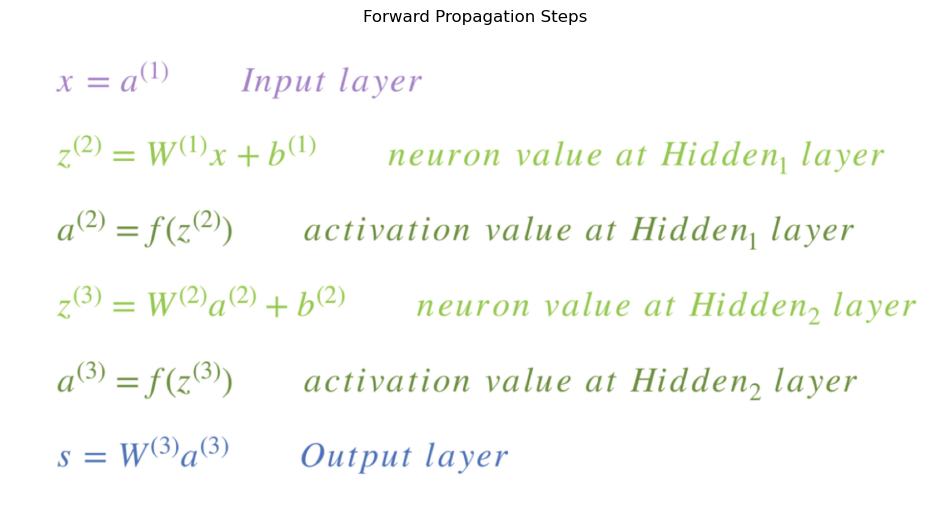

In [ ]:
show_image('Forward Propagation steps')

#### 4.3.3 Backpropagation

Let us define our goal now: we aim to calculate $\frac{\partial C}{\partial w_{22}}$.

If we know how to calculate this, all other calculations can be done in a similar fashion.

Note that

\begin{align*}
z_2^{(3)} &= W_{22}a_2^{(2)} + b^{(2)} \\
a_2^{(3)} &= f(z_2^{(3)}) \\
s &= W_2^{(3)}a_2^{(3)}
\end{align*}

It is obvious that if we want to differentiate $C$ (which depends on the final output $c$),

we need to "walk through" $a$ and $z$. In particular, let us zoom into the following sub-graph.

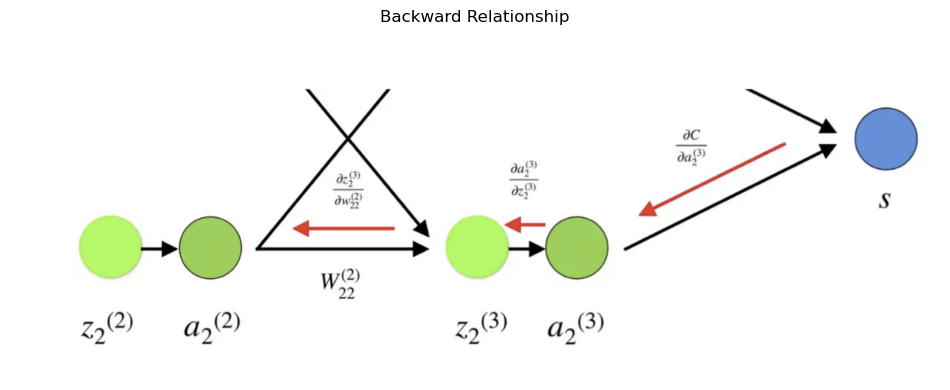

In [ ]:
show_image('Backward Relationship')

\begin{align*}
\frac{\partial C}{\partial W_{22}} & = \frac{\partial C}{\partial a_2^{(3)}} \frac{\partial a_2^{(3)}}{\partial z_2^{(3)}} \frac{\partial z_2^{(3)}}{\partial W_{22}} \\
& = \frac{\partial C}{\partial a_2^{(3)}} f'(z_2^{(3)}) a_2^{(2)}
\end{align*}

## 5. ANN Classification on Financial Ratio Dataset

The csv file ```fin-ratio.csv``` contains financial ratios of 680 securities listed on the HKEX in 2002.

There are six financial variables: Earnings yield, cash flow to price, logarithm of market value, dividend yield, book to market equity, and debt to equity.

Among these companies, there are 32 blue chips which are the Hang Seng index constituent stocks.

The last column ```HSI``` is a binary variable indicating whether a stock is a blue chip or not.

Suppose we have no information on the rules of being a blue chip stock, we want to back it out with statistical methods.

In [ ]:
fin_ratio = pd.read_csv('fin-ratio.csv')
fin_ratio

,EY,CFTP,ln_MV,DY,BTME,DTE,HSI
0,-1.8292,-0.1732,5.5405,0.000,1.0379,0.2466,0
1,-0.0797,-0.0830,6.8272,0.000,0.1275,25.4606,0
2,-2.2360,-0.6897,5.0102,0.000,-0.2959,3.3263,0
3,-1.5406,-4.1667,4.4954,0.000,-2.8571,0.9148,0
4,-0.9006,-0.3872,4.5031,0.000,2.7981,0.0753,0
...,...,...,...,...,...,...,...
675,0.0772,0.0327,7.9266,4.878,0.3303,0.3948,0
676,0.1447,0.2947,6.9895,3.774,1.6247,0.5565,0
677,0.0394,0.0324,6.9378,1.270,0.8139,0.6896,0
678,0.1153,0.1958,5.7867,0.000,2.9244,0.2420,0


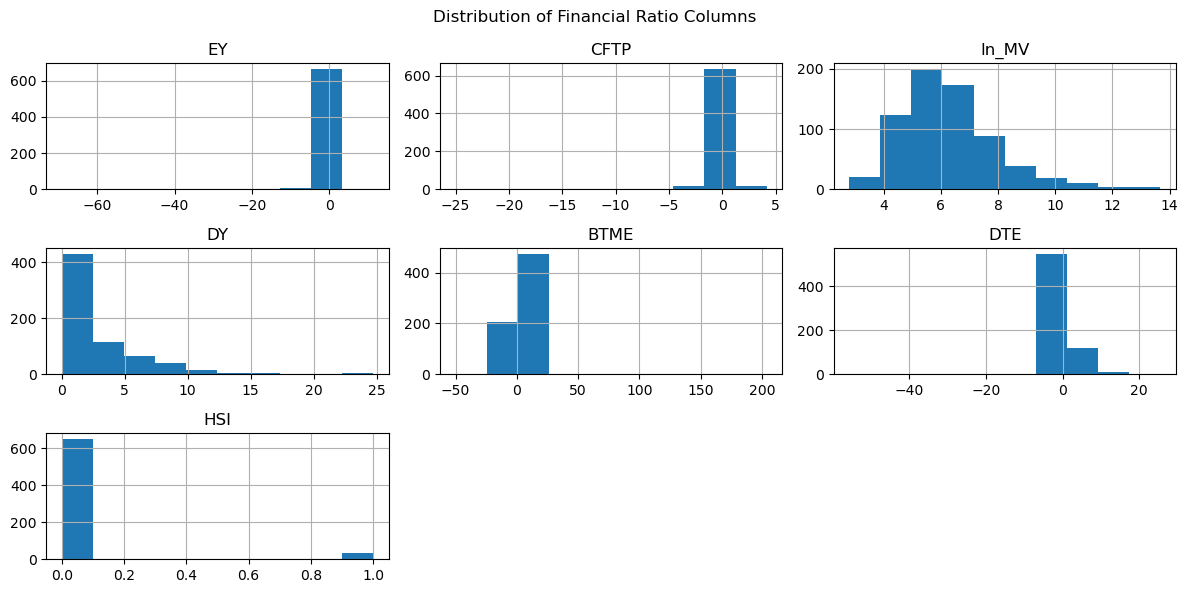

In [ ]:
fin_ratio.hist(figsize=(12, 6))
plt.suptitle('Distribution of Financial Ratio Columns');
plt.tight_layout();
plt.show();

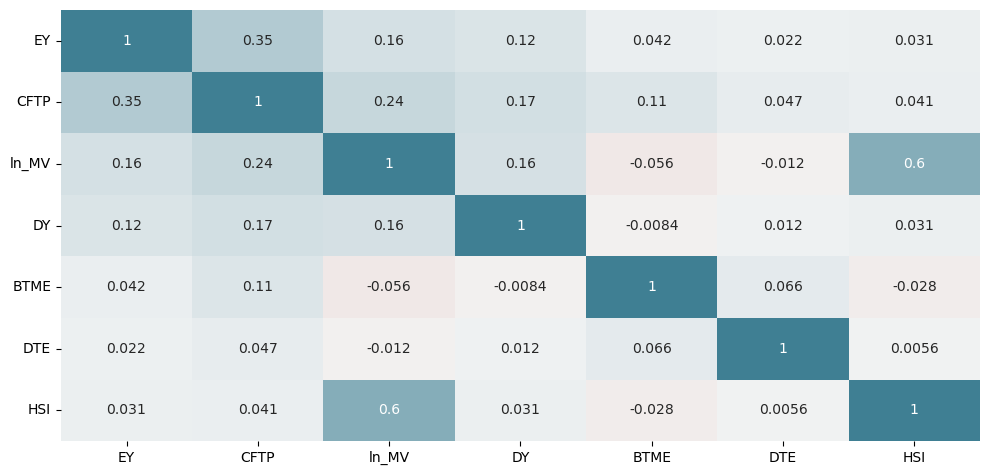

In [ ]:
pretty_heatmap(fin_ratio.corr(), center=0);

### 5.1 Split, Normalize and Oversample datasets

In [ ]:
# Split Data
test_size = 0.33
random_state = 12345

X = fin_ratio.drop(columns='HSI')
y = fin_ratio['HSI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# Normalize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).clip(-5, 5)

# Over-sample Data
oversample = SMOTE()
X_sm, y_sm = oversample.fit_resample(X_train_scaled, y_train)

### 5.2 Building and Fitting ANN

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

n_neuron = 2
metric = keras.metrics.F1Score(threshold=0.5)
optimizer = keras.optimizers.Adam(learning_rate=0.1)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='auto',
                                         start_from_epoch=10, restore_best_weights=True)

classifier = Sequential()
classifier.add(Dense(units=n_neuron, kernel_initializer='uniform', activation='relu'))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[metric])
classifier.fit(X_sm, y_sm, batch_size=128, epochs=1000, verbose=0, validation_split=0.33, callbacks=[callback]);

2025-11-16 02:26:40.434629: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-11-16 02:26:40.434645: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-11-16 02:26:40.434649: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-11-16 02:26:40.434662: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-16 02:26:40.434670: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-11-16 02:26:40.649346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-11-16 02:26:40.651346: E t

### 5.3 Assessing Training Performance

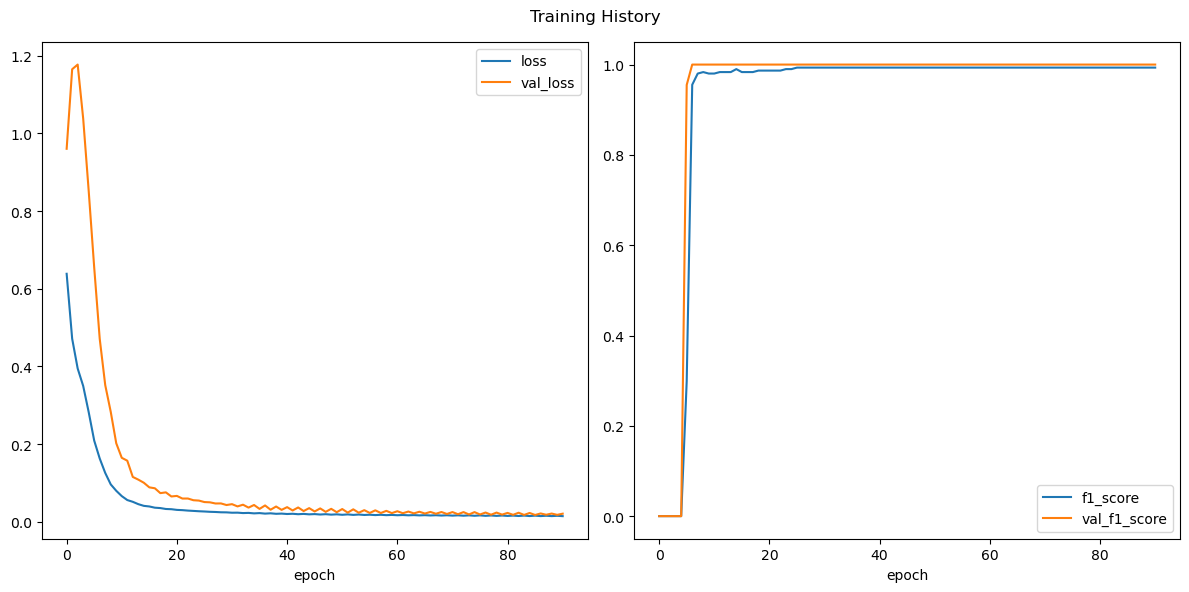

In [ ]:
train_stats = pd.DataFrame(classifier.history.history).rename_axis('epoch')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
train_stats[['loss', 'val_loss']].plot(ax=ax[0]);
train_stats[['f1_score', 'val_f1_score']].plot(ax=ax[1]);
fig.suptitle("Training History");
plt.tight_layout()
plt.show();

In [ ]:
{k: w for k, w in zip(['W1', 'b1', 'W2', 'b2'], classifier.get_weights())}

{'W1': array([[ 0.2223137 ,  3.0629961 ],
        [-0.5096538 ,  2.13642   ],
        [-1.7593966 , -2.2168078 ],
        [-0.67777663, -0.08590395],
        [-0.14172266, -6.613108  ],
        [ 0.11501961, -0.44049874]], dtype=float32),
 'b1': array([4.0525446, 3.9331121], dtype=float32),
 'W2': array([[-5.3986235],
        [-4.9034414]], dtype=float32),
 'b2': array([5.173891], dtype=float32)}

### 5.3 Assess Performance on Test Dataset

In [ ]:
X_test_scaled = scaler.transform(X_test).clip(-5, 5)
y_pred_prob = classifier.predict(X_test_scaled)
y_pred_prob = np.hstack([1 - y_pred_prob, y_pred_prob])
y_pred = y_pred_prob.argmax(axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


#### 5.3.1 Confusion Matrix

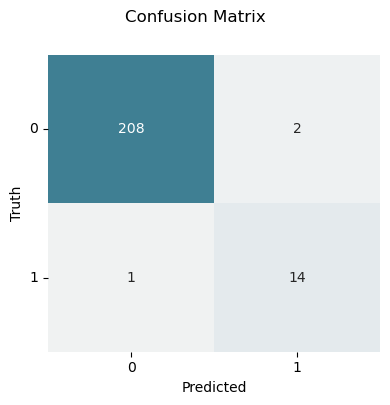

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
cm = cm.rename_axis('Truth').rename_axis('Predicted', axis=1)

pretty_heatmap(cm, title='Confusion Matrix',
               figsize=(4, 4), center=0, fmt='.0f')

#### 5.3.2 Classification Report

In [ ]:
class_rep = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
class_rep

,precision,recall,f1-score,support
0,0.995215,0.990476,0.992840,210.000000
1,0.875000,0.933333,0.903226,15.000000
accuracy,0.986667,0.986667,0.986667,0.986667
macro avg,0.935108,0.961905,0.948033,225.000000
weighted avg,0.987201,0.986667,0.986866,225.000000


#### 5.3.3 ROC Curve

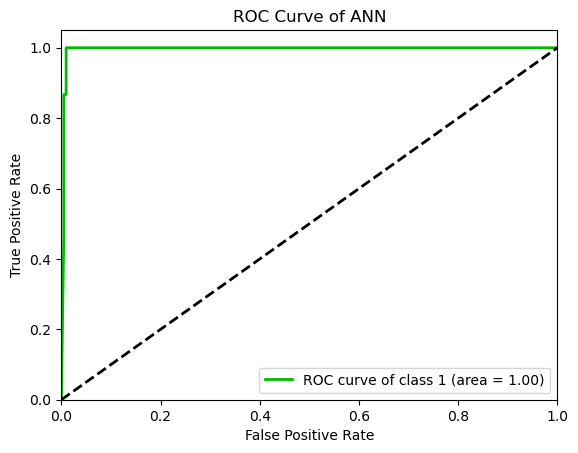

In [ ]:
plot_roc(y_test, y_pred_prob, title='ROC Curve of ANN',
         classes_to_plot=[1], plot_macro=False, plot_micro=False);

### 6. LSTM Example on Weather Dataset

Source: ```https://keras.io/examples/timeseries/timeseries_weather_forecasting/```

We will be using Jena Climate dataset recorded by the Max Planck Institute for Biogeochemistry.

The dataset consists of 19 features such as temperature, pressure, humidity etc, recorded hourly.

In [ ]:
df = pd.read_csv('jena_climate_2009_2016_hourly_processed.csv', index_col=0)
df['Date Time'] = pd.to_datetime(df['Date Time'])
df = df.set_index('Date Time').sort_index()
df.head(5)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917


### 6.1 Exploratory Data Analysis

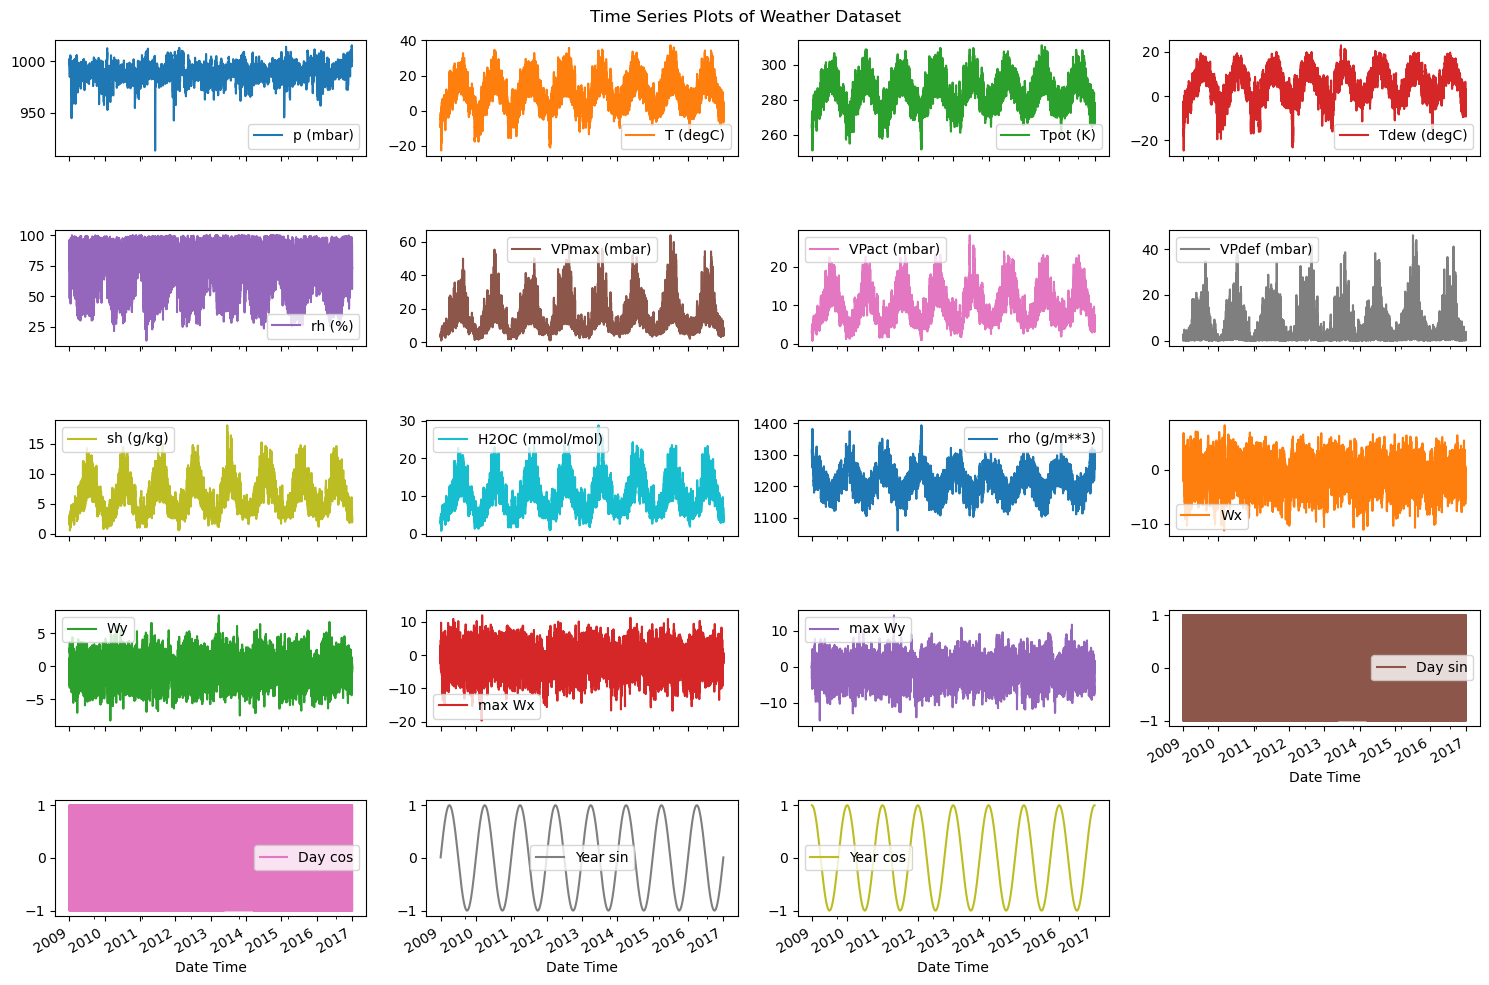

In [ ]:
df.plot(subplots=True, layout=(5, 4), figsize=(15, 10),
       title='Time Series Plots of Weather Dataset');
plt.tight_layout();
plt.show();

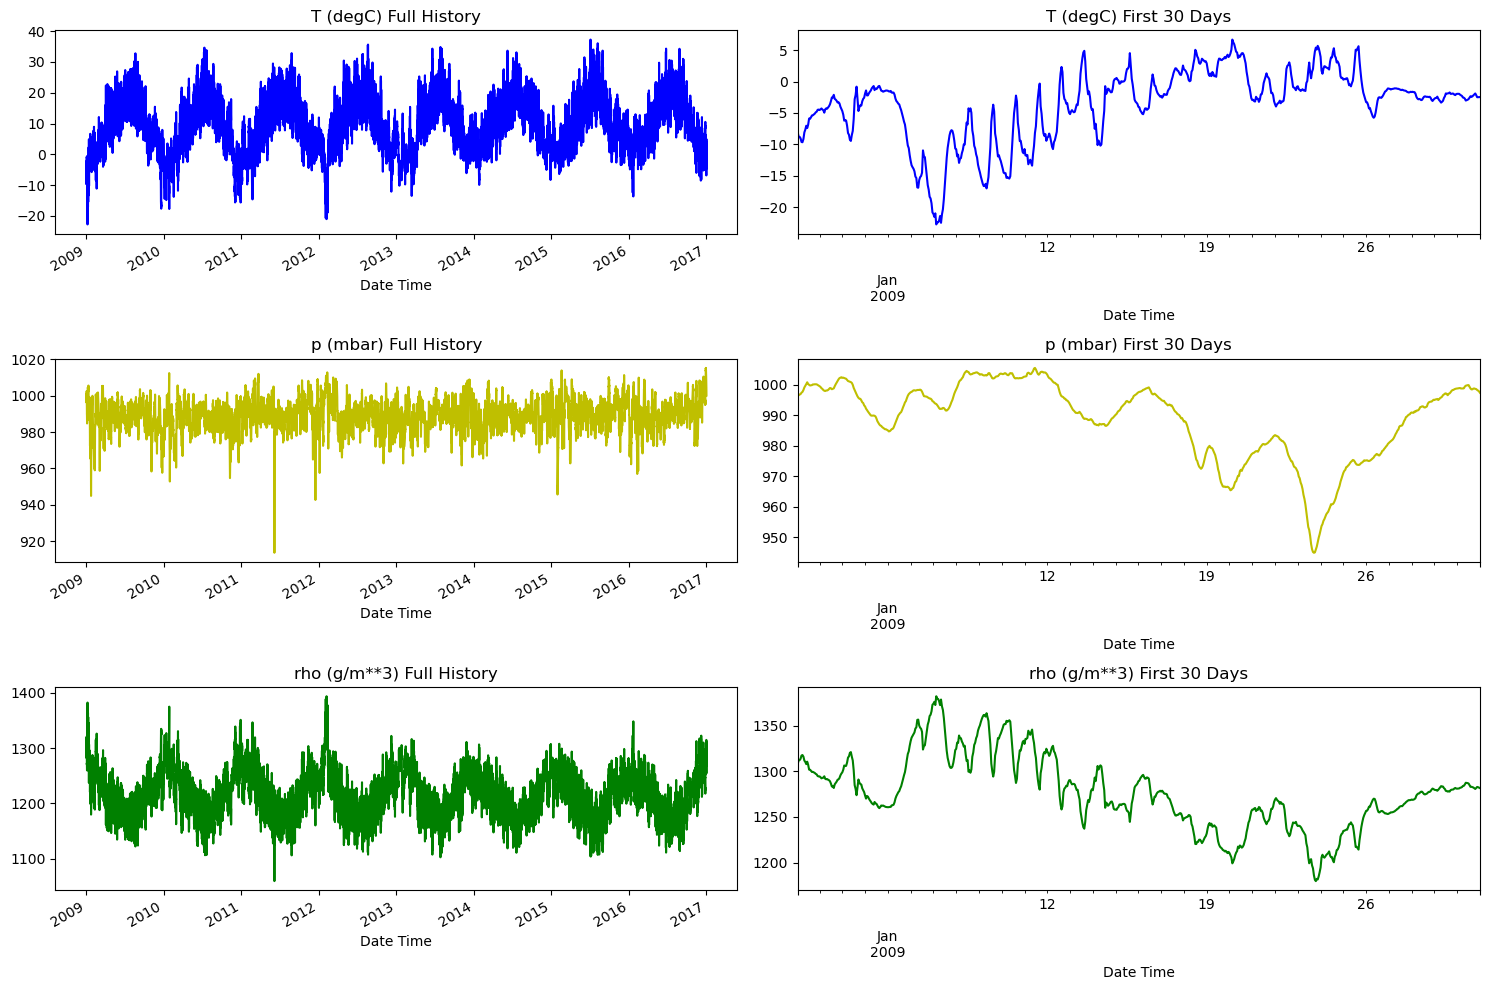

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']

fig, ax = plt.subplots(3, 2, figsize=(15, 10))

for i, (column, color) in enumerate(zip(plot_cols, ['b', 'y', 'g'])):
    df[column].plot(ax=ax[i, 0], color=color, title=f'{column} Full History')
    df[column][:24 * 30].plot(ax=ax[i, 1], color=color, title=f'{column} First 30 Days')

plt.tight_layout()
plt.show()

### 6.2 Normalize and Split Data

In [ ]:
def normalize_ts(df, year_win=3):
    hourly_win = int(24 * 365.25 * year_win)
    df_mean = df.rolling(hourly_win, min_periods=hourly_win // 3).mean()
    df_std = df.rolling(hourly_win, min_periods=hourly_win // 3).std()
    return (df - df_mean) / df_std, df_mean, df_std

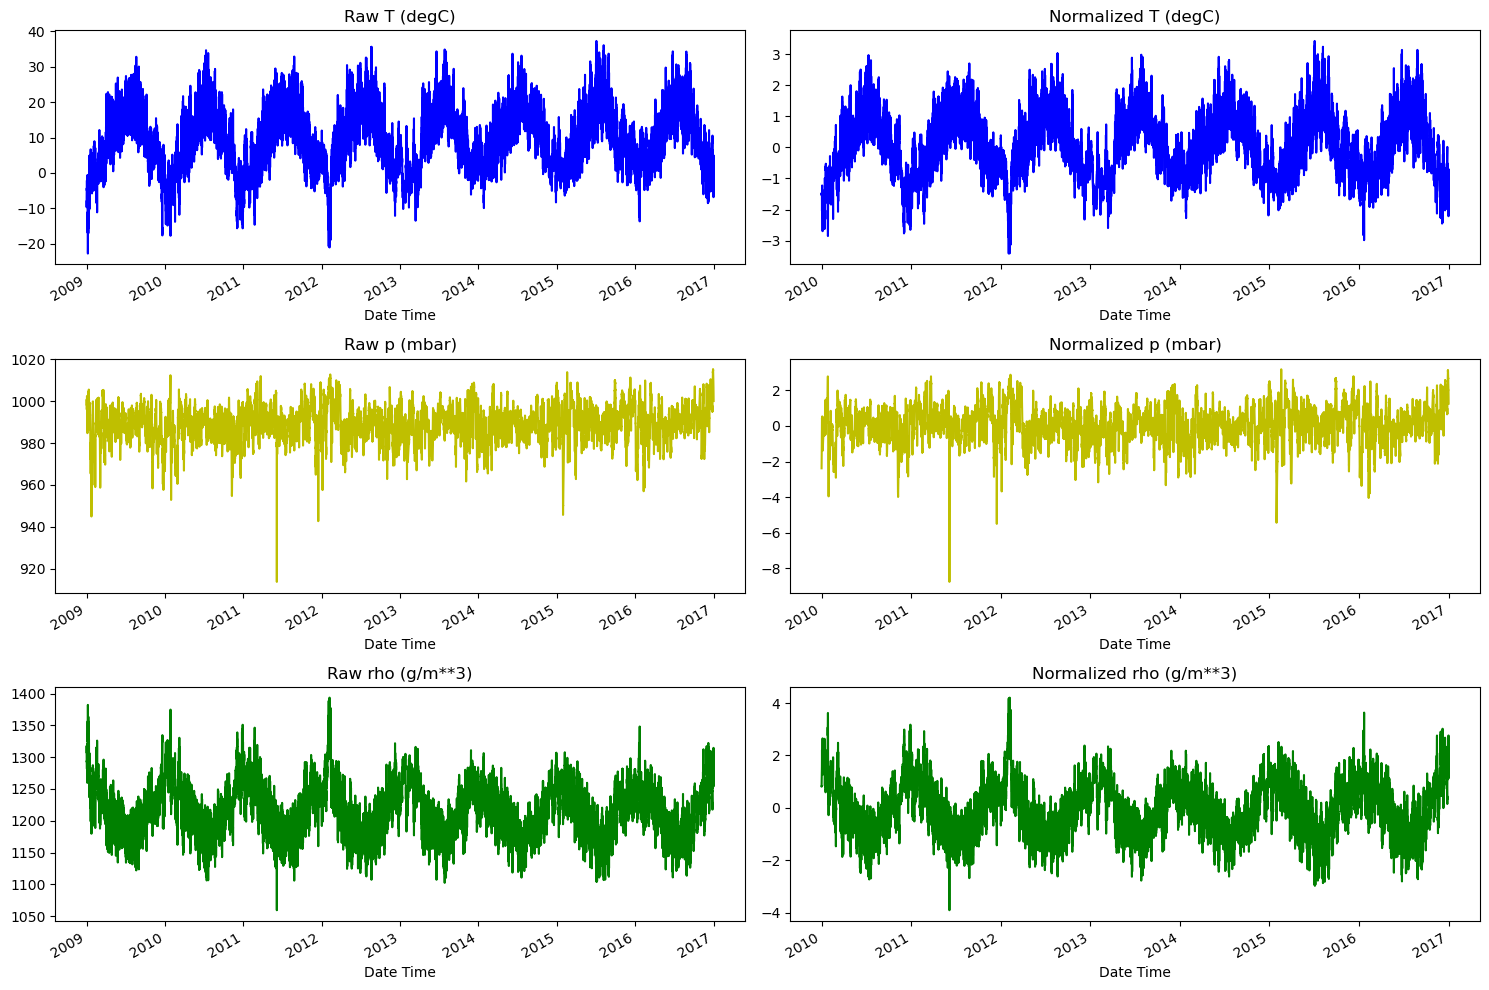

In [ ]:
df_norm, df_mean, df_std = normalize_ts(df, year_win=3)
df_norm = df_norm.dropna(how='all')

fig, ax = plt.subplots(3, 2, figsize=(15, 10))

for i, (column, color) in enumerate(zip(plot_cols, ['b', 'y', 'g'])):
    df[column].plot(ax=ax[i, 0], color=color, title=f'Raw {column}')
    df_norm[column].plot(ax=ax[i, 1], color=color, title=f'Normalized {column}')

plt.tight_layout()
plt.show()

In [ ]:
n, num_features = df_norm.shape
column_indices = {name: i for i, name in enumerate(df.columns)}

train_df = df_norm[:int(n*0.7)]
val_df = df_norm[int(n*0.7):int(n*0.9)]
test_df = df_norm[int(n*0.9):]

### 6.3 Generating Windowed Data

In [ ]:
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1, label_columns=['T (degC)'],
                             train_df=train_df, val_df=val_df, test_df=test_df)

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', wide_window.example[1].shape)
wide_window

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

### 6.4 Fitting and Evaluating LSTM Model

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

def compile_and_fit(model, window, patience=2, max_epochs=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=max_epochs,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [ ]:
history = compile_and_fit(lstm_model, wide_window)
val_performance = lstm_model.evaluate(wide_window.val, return_dict=True)
performance = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

Epoch 1/20
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0247 - mean_absolute_error: 0.0920 - val_loss: 0.0090 - val_mean_absolute_error: 0.0679
Epoch 2/20
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0064 - mean_absolute_error: 0.0560 - val_loss: 0.0083 - val_mean_absolute_error: 0.0638
Epoch 3/20
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0059 - mean_absolute_error: 0.0535 - val_loss: 0.0079 - val_mean_absolute_error: 0.0616
Epoch 4/20
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0057 - mean_absolute_error: 0.0523 - val_loss: 0.0077 - val_mean_absolute_error: 0.0604
Epoch 5/20
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0056 - mean_absolute_error: 0.0517 - val_loss: 0.0075 - val_mean_absolute_error: 0.0596
Epoch 6/20
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0054 - mean_absolute_error: 0.0510 - val_loss: 0.0075 - val_mean_absolute_error: 0.0596
Epoch 7/20
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0054 - mean_absol

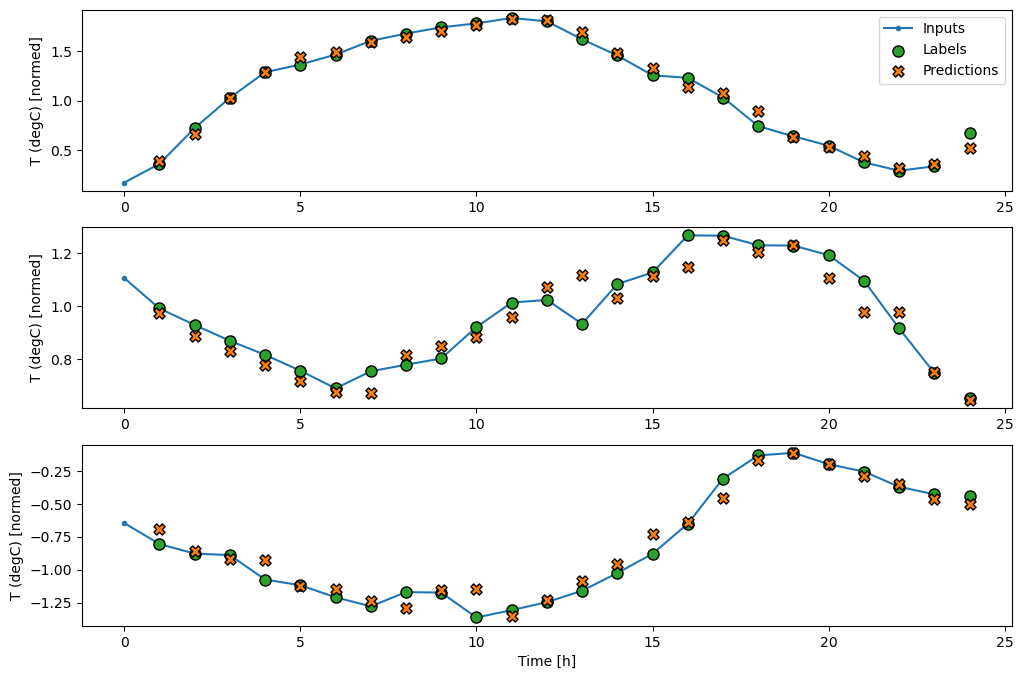

In [ ]:
wide_window.plot(lstm_model)